# FFN Classification

A notebook to apply an FFN (Feed Forward Neural Network) to classify the flower species type. We will use the the famous Iris dataset (which is now the equivalent of the hellow world dataset in the Data Science World)

Based on
- [Kaggle Notebook for Iris Classiifcation](https://www.kaggle.com/code/mohitchaitanya/simple-iris-dataset-classification-using-pytorch)
- [PyTorch for Iris Dataset](https://github.com/mattsinbot/PyTorch-for-Iris-Dataset) 
- [Iris Classification](https://github.com/yangzhangalmo/pytorch-iris/blob/master/main.py)

**Load, Visualize, Summarise Data**

sklearn comes with Iris dataset. We will load it, and do some basic visualization.
It is always a good idea to "look" at the data before (blindly) running any models.

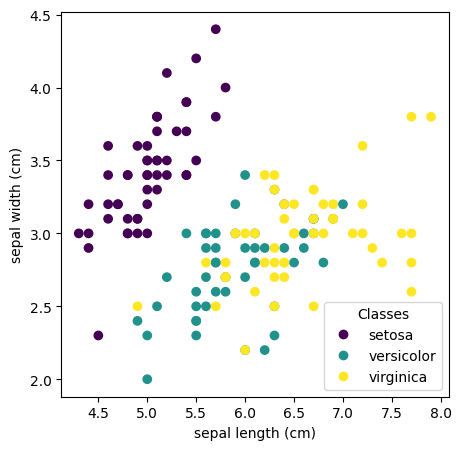

In [29]:
from sklearn.datasets import load_iris
iris = load_iris()

import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

We see that, 
1. there are four features, and it is a three class classification problem
2. Using two features (_sepal length_, and _sepal width_), it is clear that, a perceptron will not be able separate _versicolor from _virginica_ (data is not linearly separable) class. 
3. But setosa can be separated from the remaining two.

Let us look at the basic descriptions of the data.

In [2]:

print('feature name',iris.feature_names)
print('features type of data',type(iris.data))
print('features shape',iris.data.shape)
print('feature name',iris.target_names)
print('target type of data',type(iris.target))
print('target shape',iris.target.shape)


feature name ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
features type of data <class 'numpy.ndarray'>
features shape (150, 4)
feature name ['setosa' 'versicolor' 'virginica']
target type of data <class 'numpy.ndarray'>
target shape (150,)


In [3]:
print('target labels',iris.target)

target labels [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Ha. In the original dataset, the data is organized by class. If we naively prepare the mini batches (sequentially), model will only see data corresponding to only one class. This will be pretty problematic to get proper gradient signals. We should shuffle the data s.t diversity in the mini batches is maintained.

**A homework exercise** :)  

Imagine you split the data into two batches. One containing only say class 0, and other contains only class 1. During training, the model sees these two batches cyclically. Will the model ever converge. 

1. Will it converge when the data is linearly separable?
2. Will it converge when the data is not linearly separable?
3. Does  having a balanced class representation in every mini batch helps? Which way does it?

In [4]:
from datasets import Dataset
import pandas as pd
df = pd.read_csv("hf://datasets/scikit-learn/iris/Iris.csv")
df = pd.DataFrame(df)
df.head()


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [6]:
# transform species to numerics
df.loc[df.Species=='Iris-setosa', 'Target'] = 0
df.loc[df.Species=='Iris-versicolor', 'Target'] = 1
df.loc[df.Species=='Iris-virginica', 'Target'] = 2
print(df.Target.unique())
df.head()

[0. 1. 2.]


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Target
0,1,5.1,3.5,1.4,0.2,Iris-setosa,0.0
1,2,4.9,3.0,1.4,0.2,Iris-setosa,0.0
2,3,4.7,3.2,1.3,0.2,Iris-setosa,0.0
3,4,4.6,3.1,1.5,0.2,Iris-setosa,0.0
4,5,5.0,3.6,1.4,0.2,Iris-setosa,0.0


In [7]:
df.drop(['Id'],axis=1,inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Target
0,5.1,3.5,1.4,0.2,Iris-setosa,0.0
1,4.9,3.0,1.4,0.2,Iris-setosa,0.0
2,4.7,3.2,1.3,0.2,Iris-setosa,0.0
3,4.6,3.1,1.5,0.2,Iris-setosa,0.0
4,5.0,3.6,1.4,0.2,Iris-setosa,0.0


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df[df.columns[0:4]].values
y = df.Target.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.8)

In [9]:
# check that data is shuffled
print(y_train)

[2. 0. 1. 2. 2. 2. 2. 2. 2. 0. 2. 1. 0. 1. 2. 1. 0. 1. 2. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 1.]


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [12]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [13]:
class MLP(nn.Module):
    # define nn
    def __init__(self, input_dim=4, output_dim=3, hidden_dim = [128,64]):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_dim, hidden_dim[0])
        self.hidden = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.out = nn.Linear(hidden_dim[1], output_dim)
        self.relu = nn.ReLU()

    def forward(self, X):
        X = self.relu(self.input(X))
        X = self.relu(self.hidden(X))
        X = self.out(X)
        return X


In [14]:
input_dim = 4
output_dim = 3
hidden_dim = [64, 64]
model = MLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim)

In [15]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [16]:
def train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        optimizer.zero_grad()
        
        #forward feed
        output_train = model(X_train)

        #calculate the loss
        loss_train = criterion(output_train, y_train)


        #backward propagation: calculate gradients
        loss_train.backward()

        #update the weights
        optimizer.step()
        
        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")

In [17]:
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)

In [18]:
train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses)

Epoch 50/1000, Train Loss: 0.0001, Test Loss: 0.4372
Epoch 100/1000, Train Loss: 0.0000, Test Loss: 0.4097
Epoch 150/1000, Train Loss: 0.0000, Test Loss: 0.3973
Epoch 200/1000, Train Loss: 0.0000, Test Loss: 0.3885
Epoch 250/1000, Train Loss: 0.0000, Test Loss: 0.3816
Epoch 300/1000, Train Loss: 0.0000, Test Loss: 0.3758
Epoch 350/1000, Train Loss: 0.0000, Test Loss: 0.3712
Epoch 400/1000, Train Loss: 0.0000, Test Loss: 0.3676
Epoch 450/1000, Train Loss: 0.0000, Test Loss: 0.3652
Epoch 500/1000, Train Loss: 0.0000, Test Loss: 0.3635
Epoch 550/1000, Train Loss: 0.0000, Test Loss: 0.3623
Epoch 600/1000, Train Loss: 0.0000, Test Loss: 0.3614
Epoch 650/1000, Train Loss: 0.0000, Test Loss: 0.3608
Epoch 700/1000, Train Loss: 0.0000, Test Loss: 0.3603
Epoch 750/1000, Train Loss: 0.0000, Test Loss: 0.3600
Epoch 800/1000, Train Loss: 0.0000, Test Loss: 0.3597
Epoch 850/1000, Train Loss: 0.0000, Test Loss: 0.3596
Epoch 900/1000, Train Loss: 0.0000, Test Loss: 0.3597
Epoch 950/1000, Train Loss: 0

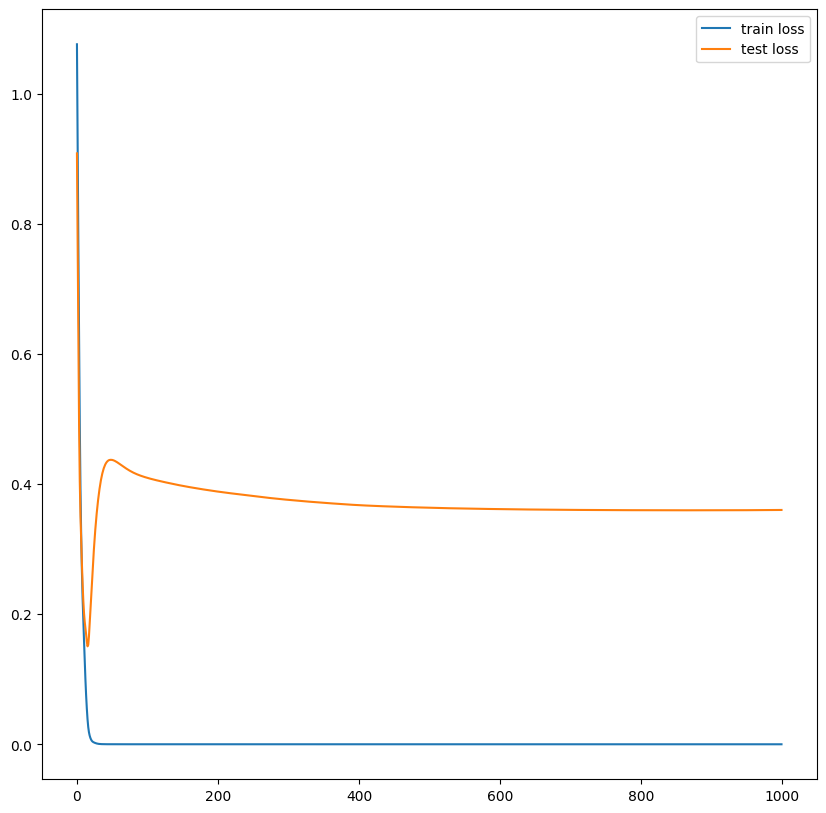

In [19]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [20]:
predictions_train = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)

In [21]:
print(predictions_train.shape)
print(type(predictions_train))

print(y_train.shape)
print(type(y_train))


torch.Size([30, 3])
<class 'torch.Tensor'>
torch.Size([30])
<class 'torch.Tensor'>


In [22]:
def get_accuracy_multiclass(pred_arr,original_arr):
    if len(pred_arr)!=len(original_arr):
        return False
    pred_arr = pred_arr.numpy()
    original_arr = original_arr.numpy()
    final_pred= []
    # we will get something like this in the pred_arr [32.1680,12.9350,-58.4877]
    # so will be taking the index of that argument which has the highest value here 32.1680 which corresponds to 0th index
    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0
    #here we are doing a simple comparison between the predicted_arr and the original_arr to get the final accuracy
    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)

In [23]:
train_acc = get_accuracy_multiclass(predictions_train,y_train)
test_acc  = get_accuracy_multiclass(predictions_test,y_test)
print(f"Training Accuracy: {round(train_acc*100,3)}")
print(f"Test Accuracy: {round(test_acc*100,3)}")

Training Accuracy: 100.0
Test Accuracy: 92.5
